In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pyts.approximation import DiscreteFourierTransform

In [2]:
train = pd.read_csv('hms-harmful-brain-activity-classification/train.csv')
print(train.head())

       eeg_id  eeg_sub_id  eeg_label_offset_seconds  spectrogram_id  \
0  1628180742           0                       0.0          353733   
1  1628180742           1                       6.0          353733   
2  1628180742           2                       8.0          353733   
3  1628180742           3                      18.0          353733   
4  1628180742           4                      24.0          353733   

   spectrogram_sub_id  spectrogram_label_offset_seconds    label_id  \
0                   0                               0.0   127492639   
1                   1                               6.0  3887563113   
2                   2                               8.0  1142670488   
3                   3                              18.0  2718991173   
4                   4                              24.0  3080632009   

   patient_id expert_consensus  seizure_vote  lpd_vote  gpd_vote  lrda_vote  \
0       42516          Seizure             3         0         0   

In [3]:
freq = 200

sample_eeg_id = train["eeg_id"].unique()[0]
sample_data=pd.read_parquet(f'hms-harmful-brain-activity-classification/train_eegs/{sample_eeg_id}.parquet')
sample_data.drop(columns=["EKG"], inplace=True)

total_duration = int(max(train[train["eeg_id"] == sample_eeg_id]["eeg_label_offset_seconds"])+50)
second_data =  sample_data["Fp1"].values.reshape(freq,total_duration)

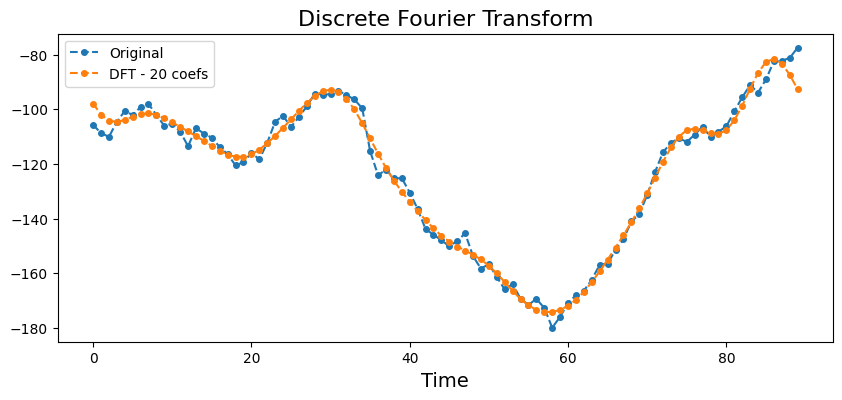

In [4]:

n_coefs = 20
dft = DiscreteFourierTransform(n_coefs=n_coefs, norm_mean=False,
                               norm_std=False)
X_dft = dft.fit_transform(second_data)

if n_coefs % 2 == 0:
    real_idx = np.arange(1, n_coefs, 2)
    imag_idx = np.arange(2, n_coefs, 2)
    X_dft_new = np.c_[
        X_dft[:, :1],
        X_dft[:, real_idx] + 1j * np.c_[X_dft[:, imag_idx],
                                        np.zeros((freq, ))]
    ]
else:
    real_idx = np.arange(1, n_coefs, 2)
    imag_idx = np.arange(2, n_coefs + 1, 2)
    X_dft_new = np.c_[
        X_dft[:, :1],
        X_dft[:, real_idx] + 1j * X_dft[:, imag_idx]
    ]
X_irfft = np.fft.irfft(X_dft_new, total_duration)

plt.figure(figsize=(10, 4))
plt.plot(second_data[1], 'o--', ms=4, label='Original')
plt.plot(X_irfft[1], 'o--', ms=4, label='DFT - {0} coefs'.format(n_coefs))
plt.legend(loc='best', fontsize=10)
plt.xlabel('Time', fontsize=14)
plt.title('Discrete Fourier Transform', fontsize=16)
plt.show()

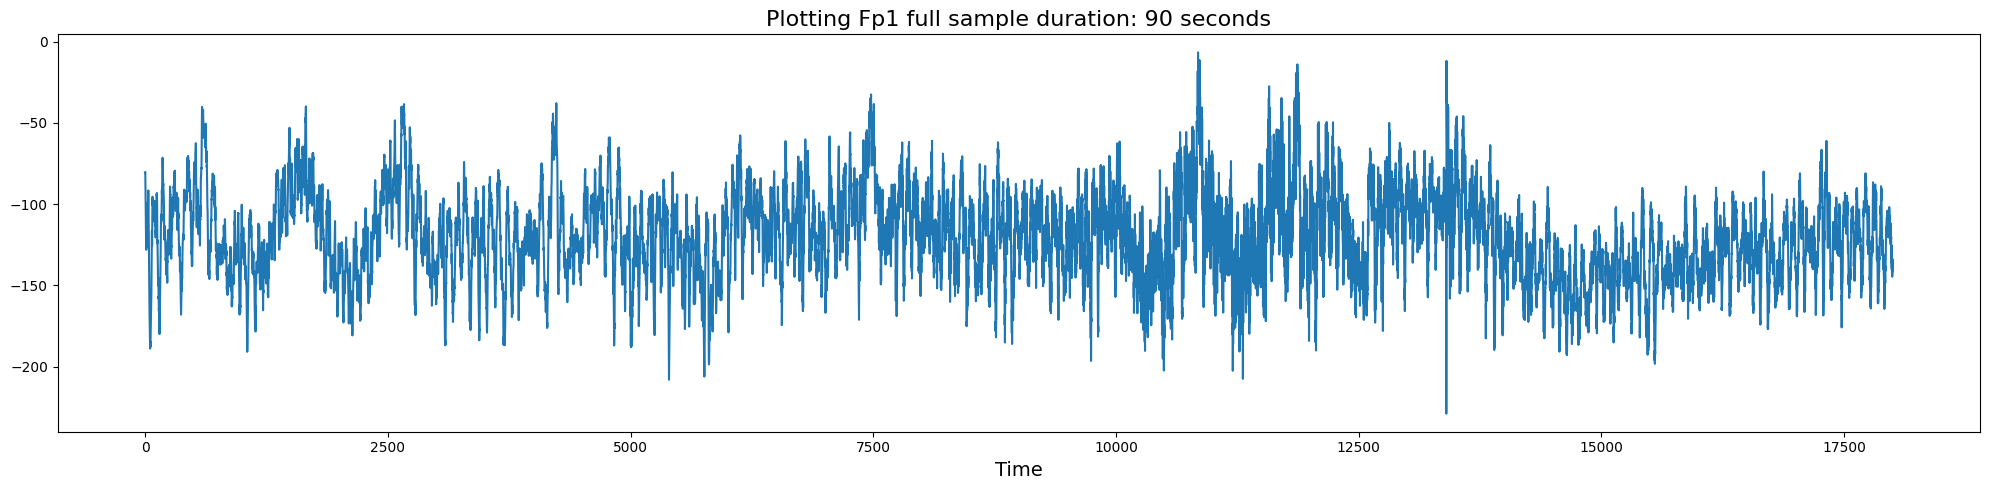

In [5]:
plt.figure(figsize=(20, 5))
plt.plot(sample_data["Fp1"])
plt.xlabel('Time', fontsize=14)
plt.title(f'Plotting Fp1 full sample duration: {total_duration} seconds', fontsize=16)
plt.tight_layout()
plt.show()

In [6]:
from pyts.image import RecurrencePlot

In [7]:
data= sample_data["Fp1"].values.reshape(1,18000)

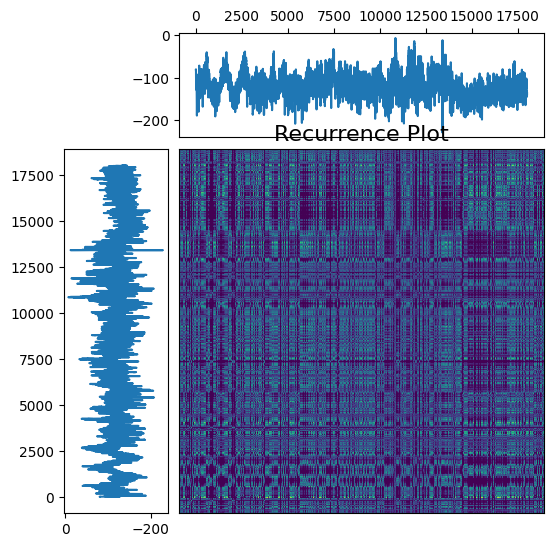

In [9]:
fig = plt.figure(figsize=(6, 6))
gs = fig.add_gridspec(2, 2,  width_ratios=(2, 7), height_ratios=(2, 7),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)


# Plot the time series on the left with inverted axes
ax_left = fig.add_subplot(gs[1, 0])
ax_left.plot(sample_data["Fp1"],np.arange(0,18000))
ax_left.invert_xaxis()

# Plot the time series on the top
ax_top = fig.add_subplot(gs[0, 1])
ax_top.plot(sample_data["Fp1"])
ax_top.xaxis.tick_top()

# Plot the recurrence plot on the bottom right
ax_rp = fig.add_subplot(gs[1, 1])
rp = RecurrencePlot(threshold='point', percentage=20)
X_rp = rp.fit_transform(data)
ax_rp.imshow(X_rp[0], origin='lower')
ax_rp.set_xticks([])
ax_rp.set_yticks([])

plt.title('Recurrence Plot', fontsize=16)
plt.show()